In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.deprecated.doc2vec import LabeledSentence
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics
#from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.multiclass import unique_labels

from collections import Counter
import matplotlib.pyplot as plt
import string
import re
import random
import glob
import itertools

import json

np.random.seed(1234)
random.seed(1234)

porter = PorterStemmer()
punctuation_dictionary = {s:None for s in list(string.punctuation)}
punctuation_dictionary["-"] = "_"

punctuation_translator = str.maketrans(punctuation_dictionary)

def text_cleaner(text, punctuation_translator, stemmer):
    text = "".join(re.split('xa0',text))
    text = str(text).translate(punctuation_translator)
    text = text.lower()
    text = porter.stem(text)
    return(text)

## Load Speech & Clean

In [2]:
SubSpeech = pd.read_csv('SubSpeech_coded_cleaned.csv')
SubSpeech.head()

,Candidate,Chanel,City,Content,Date,Day,Description,Month,Speech_index,State,SubContent,Subject,Subspeech_index,Title,Type,URL,Year,Pop
0,Donald J. Trump,NaN,NaN,"\nPRESIDENT DONALD TRUMP: Thank you, thank you...","\nNovember 26, 2018",26.0,NaN,November,Speech0,NaN,"['', ""PRESIDENT DONALD TRUMP: Thank you, thank...",NaN,Speech0_0:10,"\nRemarks at a ""Make America Great Again"" Rall...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,NaN
1,Donald J. Trump,NaN,NaN,"\nPRESIDENT DONALD TRUMP: Thank you, thank you...","\nNovember 26, 2018",26.0,NaN,November,Speech0,NaN,['The unemployment rate just hit the lowest le...,NaN,Speech0_10:20,"\nRemarks at a ""Make America Great Again"" Rall...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,NaN
2,Donald J. Trump,NaN,NaN,"\nPRESIDENT DONALD TRUMP: Thank you, thank you...","\nNovember 26, 2018",26.0,NaN,November,Speech0,NaN,"[""And I'll tell you, a little—a little tricky ...",NaN,Speech0_20:30,"\nRemarks at a ""Make America Great Again"" Rall...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,NaN
3,Donald J. Trump,NaN,NaN,"\nPRESIDENT DONALD TRUMP: Thank you, thank you...","\nNovember 26, 2018",26.0,NaN,November,Speech0,NaN,"['You are here, he is here to help elect Cindy...",NaN,Speech0_30:40,"\nRemarks at a ""Make America Great Again"" Rall...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,NaN
4,Donald J. Trump,NaN,NaN,"\nPRESIDENT DONALD TRUMP: Thank you, thank you...","\nNovember 26, 2018",26.0,NaN,November,Speech0,NaN,"[""What a great crowd we have tonight for you. ...",NaN,Speech0_40:50,"\nRemarks at a ""Make America Great Again"" Rall...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,NaN


In [7]:
len(SubSpeech.Speech_index.unique()), len(SubSpeech.Subspeech_index)

(4363, 17453)

In [5]:
len(SubSpeech[SubSpeech.Pop.isin(['accept','reject'])].Speech_index.unique())

65

In [4]:
SubSpeech["clean_text"] = SubSpeech["SubContent"].apply(lambda x: text_cleaner(x, punctuation_translator, porter))

In [6]:
#SubSpeech.head()

In [7]:
phrases1 = Phrases(map(lambda x: x.split(), SubSpeech["clean_text"].tolist()))
phrases2 = Phrases(phrases1[map(lambda x: x.split(), SubSpeech["clean_text"].tolist())])
SubSpeech["phrased_text"] = SubSpeech["clean_text"].apply(lambda x: " ".join(phrases2[phrases1[x.split()]]))

## Doc2Vev Model

In [8]:
docs = list(zip(SubSpeech["phrased_text"].tolist(), SubSpeech["Subspeech_index"].tolist()))


## Define an iterator to feed documents and tags to Doc2Vec
class Sentences(object):
  def __init__(self, docs):
    self.docs = docs
  def __iter__(self):
    for doc in self.docs:
      yield TaggedDocument(words=str(doc[0]).split(), tags=[doc[1]])

## Train and save models
model = Doc2Vec(Sentences(docs), vector_size=150, window=10, min_count=5, negative=10, epochs=20, dm=0, dbow_words=1)

In [37]:
#model.wv.save_word2vec_format("doc2vec_wordvecs.txt", binary=False)

In [47]:
model.save("doc2vec_wordvecs.model")

In [69]:
model.wv.most_similar('democracy')

[('freedom', 0.6257390975952148),
 ('democracies', 0.5844771862030029),
 ('human_rights', 0.5696552991867065),
 ('democraci', 0.566604495048523),
 ('liberty', 0.5647825002670288),
 ('dictatorship', 0.5637447834014893),
 ('communism', 0.5521410703659058),
 ('stability', 0.5427613854408264),
 ('guardian_genius', 0.5422051548957825),
 ('freedoms', 0.5421812534332275)]

In [19]:
#Most similar phrase to populist doc
populist_index = list(set(SubSpeech.loc[SubSpeech['Pop'] == "accept", "Subspeech_index"].tolist()))
print(len(populist_index))
i = 13

value = SubSpeech.loc[SubSpeech['Subspeech_index']==populist_index[i]]["phrased_text"].tolist()
print(value)
model.wv.most_similar([model.docvecs[populist_index[i]]])

62
['many business people including many of my competitors were not able to survive companies jobs and opportunities were lost – and lives were destroyed as tens of thousands of people were put out of work some of the biggest and strongest people and companies went_bankrupt yet today my company is bigger stronger with far_greater assets and more premium properties than_ever_before that did not happen by chance or luck – it happened by action and talent i was able to use the tax_laws of this country and my business acumen to dig out of this real_estate depression when few others did in those most_difficult times when so_many had their_backs to the wall i reached within myself and delivered for my company my employees my family and the communities where my properties existed those who spend their entire lives within the confines of government work and who know virtually_nothing of business fail to understand the skill dedication and sheer grit it takes for a company to climb out of an ec

[('highly_successful', 0.48077499866485596),
 ('mergers', 0.4625874161720276),
 ('hold_public_office', 0.45705559849739075),
 ('firms', 0.45196157693862915),
 ('bundled', 0.4493178129196167),
 ('early_nineties', 0.4449384808540344),
 ('clinton_machine', 0.4444372057914734),
 ('more_than_200_million', 0.4414912462234497),
 ('crisi', 0.4411012530326843),
 ('condos', 0.43967169523239136)]

## Classification

In [44]:
SubSpeech = pd.read_csv('SubSpeech_coded_cleaned.csv')

In [48]:
model = Word2Vec.load("doc2vec_wordvecs.model")

In [20]:
SubSpeech.Pop.replace('accept',1, inplace=True)

In [21]:
SubSpeech.Pop.replace('reject',0, inplace=True)

In [22]:
SubSpeech.Pop.value_counts()

0.0    357
1.0     62
Name: Pop, dtype: int64

In [23]:
labelled_data = SubSpeech.loc[SubSpeech['Pop'].isin([0,1])][["Subspeech_index","Pop"]]
labelled_data = labelled_data.groupby(["Subspeech_index"]).mean()
print(labelled_data.head())
print(labelled_data.shape)

X = np.asarray([model.docvecs[i] for i in labelled_data.index.tolist()])
Y = np.asarray(labelled_data['Pop'].tolist(), dtype="int")

# ## Get the words most closely associated with all of the "populist" articles
# for k, v in model.most_similar(model.docvecs[populist_indices], topn=50):
#   print(k) 

kf = KFold(n_splits=5)
print(X.shape)
print(Y)

                    Pop
Subspeech_index        
Speech1025_0:10     0.0
Speech1025_100:110  0.0
Speech1025_10:20    0.0
Speech1025_110:120  0.0
Speech1025_120:130  0.0
(419, 1)
(419, 150)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AUC: 0.9097496706192358
Accuracy: 0.875
Mean AUC: 0.9097496706192358
Mean Accuracy: 0.875


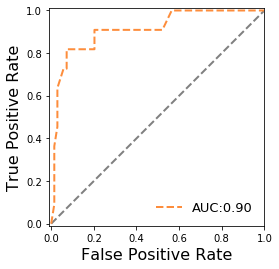

In [33]:
auc_scores_d2v = []
accuracy_scores_d2v = []

np.random.seed(234) 
random.seed(234)

plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['savefig.transparent'] = 'false'

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.axes().set_aspect('equal')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
#plt.title('ROC curve', fontsize=16)
for i in range(1):
    ## Create a test and train set
    test_size = 80
    test_set = random.sample(range(0,len(Y)), test_size)
    train_set = list(set(list(range(0,len(Y)))) - set(test_set))
    ## Initialize a gradient boosting classifier
    gbc = RandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0, class_weight="balanced")
  # gbc = GradientBoostingClassifier(loss="deviance",
  #   learning_rate=0.1,
  #   n_estimators=20000,
  #   subsample=1.0,
  #   min_samples_split=2,
  #   min_samples_leaf=1,
  #   max_depth=4,
  #   init=None,
  #   random_state=None,
  #   max_features=None,
  #   verbose=0)
    gbc = CalibratedClassifierCV(gbc, cv=2, method="isotonic")
    ## Fit the model to the training set
    gbc.fit(X[np.asarray(train_set, dtype="int")], Y[np.asarray(train_set, dtype="int")])
    ## Predict out-of-sample on the test set and compute AUC
    preds = gbc.predict_proba(X[np.asarray(test_set, dtype="int")])
    fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y[np.asarray(test_set, dtype="int")], preds[:,1], pos_label=1)
    auc_scores_d2v = auc_scores_d2v + [metrics.auc(fpr_d2v, tpr_d2v)]
    plt.plot(fpr_d2v, tpr_d2v, lw=2, linestyle='--', label="AUC:" + str(metrics.auc(fpr_d2v, tpr_d2v))[0:4],color='#fd8d3c')
    print("AUC: "+str(metrics.auc(fpr_d2v, tpr_d2v)))
    accuracy_d2v = metrics.accuracy_score(Y[np.asarray(test_set, dtype="int")], gbc.predict(X[np.asarray(test_set, dtype="int")]), normalize=True)
    accuracy_scores_d2v = accuracy_scores_d2v + [accuracy_d2v]
    print("Accuracy: " + str(accuracy_d2v))
leg = plt.legend(framealpha = 0,loc='lower right', fontsize=13)
for text in leg.get_texts():
    plt.setp(text, color = 'black')
plt.savefig('images/d2v_rocs.png')
# vocab = model.wv.vocab.keys()
# vectors = [model[v] for v in vocab]
# vectors = np.asarray(vectors)

# word_preds = gbc.predict_proba(vectors)
# word_scores = dict(zip(vocab, word_preds[:,1].tolist()))
# sorted_keys = sorted(word_scores, key=word_scores.get, reverse=True)
# for r in sorted_keys[0:100]:
#     print(str(r))
print("Mean AUC: " + str(np.mean(auc_scores_d2v)))
print("Mean Accuracy: " + str(np.mean(accuracy_scores_d2v)))

In [34]:
predicted = gbc.predict(X[np.asarray(test_set, dtype="int")])
confusion = confusion_matrix(Y[np.asarray(test_set, dtype="int")], predicted)
print(confusion)

[[68  1]
 [ 9  2]]


In [35]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[68  1]
 [ 9  2]]


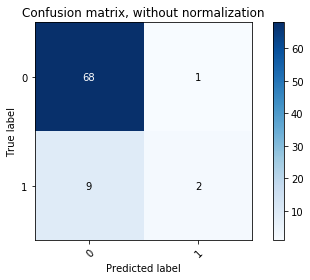

In [36]:
plot_confusion_matrix(Y[np.asarray(test_set, dtype="int")], predicted, 
                      title='Confusion matrix, without normalization')

In [37]:
scores = gbc.predict_proba(np.asarray([model.docvecs[a] for a in SubSpeech["Subspeech_index"]]))
predictions = gbc.predict(np.asarray([model.docvecs[a] for a in SubSpeech["Subspeech_index"]]))

In [38]:
SubSpeech["Pop_class"] = predictions.tolist()
SubSpeech["Pop_prob"] = scores[:,1].tolist()

In [39]:
SubSpeech["Pop_prob"].describe()

count    17453.000000
mean         0.092572
std          0.097319
min          0.000000
25%          0.015625
50%          0.076923
75%          0.148352
max          0.739130
Name: Pop_prob, dtype: float64

In [77]:
#SubSpeech.sort_values(by=['Pop_prob']).tail()

In [65]:
SubSpeech["Pop_class"] = [1 if x>=0.32 else 0 for x in SubSpeech["Pop_prob"]]

In [66]:
np.mean(SubSpeech["Pop_class"])

0.035695868905059304

Confusion matrix, without normalization
[[355   2]
 [ 11  51]]


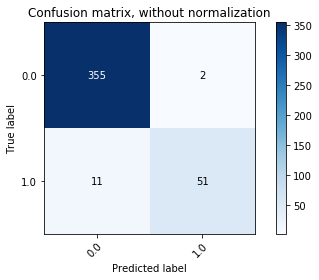

In [67]:
plot_confusion_matrix(SubSpeech.loc[SubSpeech['Pop'].isin([0,1])]["Pop"], 
                      SubSpeech.loc[SubSpeech['Pop'].isin([0,1])]["Pop_class"])

In [63]:
test_proba = gbc.predict_proba(X[np.asarray(test_set, dtype="int")])[:,1]
test_class = [1 if x>=0.32 else 0 for x in test_proba]

Confusion matrix, without normalization
[[67  2]
 [ 4  7]]


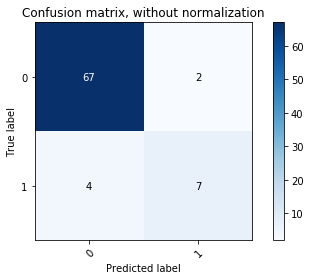

In [64]:
plot_confusion_matrix(Y[np.asarray(test_set, dtype="int")], test_class, 
                      title='Confusion matrix, without normalization')

In [68]:
SubSpeech.to_csv('SubSpeech_predicted_update.csv', index=False)

## Blind Test (prodigy)

In [128]:
SubSpeech_predicted = pd.read_csv('SubSpeech_predicted.csv')

In [128]:
#SubSpeech_predicted.head()

In [129]:
virgintext = SubSpeech.loc[-SubSpeech['Pop'].isin([0,1])]

In [130]:
virgintext = virgintext[virgintext.Candidate != 'Donald J. Trump']

In [132]:
virgintext[virgintext.Pop_class==1].Candidate.value_counts()

Barack Obama             12
Bernie Sanders            9
John Edwards              5
Robert Dole               5
Hillary Clinton           5
Ted Cruz                  3
Rick Perry                3
Mitt Romney               3
John F. Kerry             3
Bill Richardson           2
John McCain               2
Scott Walker              2
Mike Pence                1
Newt Gingrich             1
Albert Gore, Jr.          1
Franklin D. Roosevelt     1
John F. Kennedy           1
Mike Huckabee             1
Fred Thompson             1
Rudy Giuliani             1
Jon Huntsman              1
Name: Candidate, dtype: int64

In [139]:
#virgintext.Subspeech_index[virgintext.Pop_class==1]

In [133]:
blind_index = list(np.random.choice(virgintext.Subspeech_index[virgintext.Pop_class==1], 10, replace=False)) + list(
    np.random.choice(virgintext.Subspeech_index[virgintext.Pop_class==0], 5, replace=False)) 

In [134]:
blindspeech_index = [re.split('_',x)[0] for x in blind_index]

In [135]:
blindspeech_sample = SubSpeech[['Speech_index', 'Subspeech_index','SubContent']].loc[
    SubSpeech.Speech_index.isin(blindspeech_index)]

In [136]:
blindspeech_sample['text'] = [blindspeech_sample.Subspeech_index[i] + '## ' + ''.join(blindspeech_sample.SubContent[i])
                           for i in blindspeech_sample.Subspeech_index.index]

In [137]:
len(blindspeech_sample.Subspeech_index)

117

In [138]:
blindspeech_sample.to_csv('blindspeech_sample2.csv')

In [11]:
blindspeech_sample = pd.read_csv("blindspeech_sample2.csv")

In [152]:
SubSpeech.loc[
    SubSpeech.Speech_index.isin(blindspeech_index)].Year.value_counts()

2008    50
1996    24
2011    12
2015    10
2016     9
2007     6
2004     6
Name: Year, dtype: int64

In [20]:
#SubSpeech_predicted.Candidate[SubSpeech_predicted.Speech_index.isin(blindspeech_sample.Speech_index)]

In [117]:
len(SubSpeech.Speech_index.loc[SubSpeech['Pop'].isin([0,1])].value_counts())

47

In [162]:
SubSpeech_predicted.loc[SubSpeech_predicted.Speech_index == "Speech1754"]

,Unnamed: 0,Speech_index,SubContent,Subspeech_index,Candidate,Title,Date,Content,Type,URL,Year,Month,Day,Pop,Pop_class,Pop_prob
9480,9480,Speech1754,"['', 'A few weeks ago, President Clinton looke...",Speech1754_0:10,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.047170
9481,9481,Speech1754,['A mother of two who is worried her job may b...,Speech1754_10:20,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.147170
9482,9482,Speech1754,['Let me briefly touch upon each of these four...,Speech1754_20:30,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.083333
9483,9483,Speech1754,"['If you go to any Main Street in America, and...",Speech1754_30:40,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,1,0.438596
9484,9484,Speech1754,['In designing a new tax system I will ensure ...,Speech1754_40:50,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.158550
9485,9485,Speech1754,"['As President, I would direct every Departmen...",Speech1754_50:70,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.128788


### Merge Blind Test Annotation and Test

In [23]:
with open('Annotations/blind_test1117.jsonl', 'r') as annotation_jsonl:
    annotation_list = list(annotation_jsonl)

In [3]:
len(annotation_list)

68

In [6]:
coded = {}
for annotation in annotation_list:
    annotation_dict = json.loads(annotation)
    coded[annotation_dict['text'].split('##')[0]] = annotation_dict['answer']

In [7]:
len(coded)

68

In [8]:
blindtest_coded = pd.DataFrame.from_dict(coded, orient='index')

In [10]:
blindtest_coded = blindtest_coded.rename(columns={0:'Pop'})

In [12]:
blindtest_coded['Subspeech_index'] = blindtest_coded.index

In [13]:
SubSpeech = pd.read_csv('SubSpeech_coded.csv')

In [16]:
blindtest = SubSpeech.merge(blindtest_coded, how = 'outer', left_on='Subspeech_index', right_on = 'Subspeech_index')

In [18]:
#blindtest

### Update training data with all annotated

In [24]:
with open('Annotations/test_annotation.jsonl', 'r') as annotation_jsonl:
    annotation_list += list(annotation_jsonl)

In [25]:
with open('Annotations/pop_code1117.jsonl', 'r') as annotation_jsonl:
    annotation_list += list(annotation_jsonl)

In [26]:
len(annotation_list)

268

In [27]:
coded = {}
for annotation in annotation_list:
    annotation_dict = json.loads(annotation)
    coded[annotation_dict['text'].split('##')[0]] = annotation_dict['answer']

coded_data = pd.DataFrame.from_dict(coded, orient='index')
coded_data = coded_data.rename(columns={0:'Pop'})
coded_data['Subspeech_index'] = coded_data.index

In [29]:
len(coded_data.Pop)

268

In [30]:
Sub_Speech = pd.read_csv('SubSpeech.csv')

In [31]:
SubSpeech_coded = Sub_Speech.merge(coded_data, how = 'outer', left_on='Subspeech_index', right_on = 'Subspeech_index')

In [34]:
#SubSpeech_coded.head()

In [35]:
SubSpeech_coded.to_csv("SubSpeech_coded.csv", index=False)